In [1]:
import os
import pandas as pd
import numpy as np
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from pycorenlp import StanfordCoreNLP
import matplotlib.pyplot as plt
import time
import seaborn as sns
from textblob import TextBlob
from scipy import stats
from sentiment import NTA
import scipy
import pickle
import time
from sklearn.linear_model import LinearRegression
sns.set()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Evaluation Data

In [2]:
def normalize(score):
    return score * 2 - 1

def get_authors():
    authors = os.listdir('./data/scale_data/scaledata')
    return [author for author in authors if author[0] != '.']

def get_data_for_author(author):
    fp_base = './data/scale_data/scaledata'
    fp_subj = f'{fp_base}/{author}/subj.{author}'
    fp_rating = f'{fp_base}/{author}/rating.{author}'
    with open(fp_subj, 'r') as f:
        texts = f.read().split('\n')
    with open(fp_rating, 'r') as f:
        ratings = f.read().split('\n')
    data = []
    for i in range(len(texts)):
        if ratings[i].strip() == '':
            ratings[i] = 0
        data.append({'content': texts[i], 'rating': normalize(float(ratings[i]))})
    return data

def get_data_df():
    authors = get_authors()
    data = []
    for author in authors:
        data += get_data_for_author(author)
    return pd.DataFrame.from_dict(data)

df = get_data_df()
df.head()

,content,rating
0,i didn't expect ghost in the machine to be thi...,-0.90
1,"admittedly , with a title like the mangler , y...",-0.90
2,"cast : christopher lambert , natasha henstridg...",-0.90
3,"inevitably , someone is going to ask me why i ...",-0.90
4,ernest : the one-joke concept that refuses to ...,-0.82


## Sentiment Helpers

In [3]:
def get_vader_analyzer():
    return SentimentIntensityAnalyzer()

def get_vader_sentiment(analyzer, sentence, compound=True):
    if compound:
        return analyzer.polarity_scores(sentence)['compound']
    return analyzer.polarity_scores(sentence)

def get_stanford_nlp():
    # java -mx4g -cp "*" edu.stanford.nlp.pipeline.StanfordCoreNLPServer -port 9000 -timeout 15000
    return StanfordCoreNLP('http://localhost:9000')

def get_stanford_sentiment(nlp, sentence, sum_product=True):
    try:
        properties = {'annotators': 'sentiment', 'outputFormat': 'json', 'timeout': 30000}
        res = nlp.annotate(sentence, properties=properties)
        if sum_product:
            dist = res['sentences'][0]['sentimentDistribution']
            return np.dot(np.array(dist), np.array([0, 1, 2, 3, 4]))
        return int(res['sentences'][0]['sentimentValue'])
    except:
        return 2

def attach_sentiment(df):
    vader_analyzer = get_vader_analyzer()
    stanford_nlp = get_stanford_nlp()
    print('Starting VADER analysis...')
    df['vader_sent'] = df['content'].apply(lambda x: get_vader_sentiment(vader_analyzer, x))
    print('Completed VADER analysis.\nStarting Stanford NLP analysis...')
    df['stanford_sent'] = df['content'].apply(lambda x: get_stanford_sentiment(stanford_nlp, x[:300]))
    print('Completed Stanford NLP analysis.')
    return df

def normalize_stanford_sentiment(df):
    df['norm_stanford_sent'] = df['stanford_sent'].apply(lambda x: float(x - 2) / 2)
    return df

def get_textblob_sentiment(text):
    return float(TextBlob(text).sentiment.polarity)

def attach_textblob(df):
    df['textblob_sent'] = df['content'].apply(lambda x: float(TextBlob(x).sentiment.polarity))
    return df

'''
# UNCOMMENT TO RERUN - will take a loooooooooong time...
df = attach_sentiment(df)
df = normalize_stanford_sentiment(df)
with open('./data/sentiment_performance_df.pkl', 'wb') as f:
    pickle.dump(df, f)
'''

with open('./data/sentiment_performance_df.pkl', 'rb') as f:
    df = pickle.load(f)

df = attach_textblob(df)
df['stanford_delta'] = df['rating'] - df['norm_stanford_sent']
df['vader_delta'] = df['rating'] - df['vader_sent']
df['textblob_delta'] = df['rating'] - df['textblob_sent']

In [6]:
df[50:55][['content', 'rating', 'vader_sent', 'norm_stanford_sent', 'textblob_sent', \
          'stanford_delta', 'vader_delta', 'textblob_delta']].rename(columns={'rating': 'ground truth', 
          'stanford_delta': 'stanford_error', 'vader_delta': 'vader_error', 'textblob_delta': 'textblob_error'})

,content,ground truth,vader_sent,norm_stanford_sent,textblob_sent,stanford_error,vader_error,textblob_error
50,"starring : kim basinger , terence stamp , val ...",-0.44,0.3075,-0.521435,0.002706,0.081435,-0.7475,-0.442706
51,"starring : william sadler , billy zane , jada ...",-0.44,-0.7404,-0.646568,-0.049201,0.206568,0.3004,-0.390799
52,considering what happens after hatch harrison ...,-0.44,-0.9844,-0.332723,0.044710,-0.107277,0.5444,-0.484710
53,"if you want a good chase movie , see the fugit...",-0.42,-0.9923,0.308009,-0.099146,-0.728009,0.5723,-0.320854
54,i expect a certain number of contrivances in a...,-0.42,0.8358,-0.293295,0.019792,-0.126705,-1.2558,-0.439792


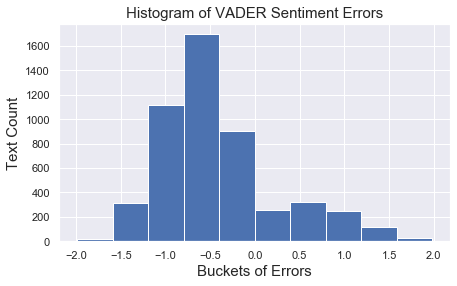

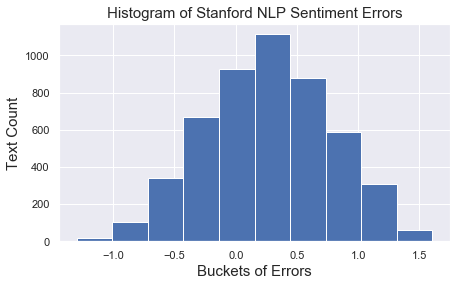

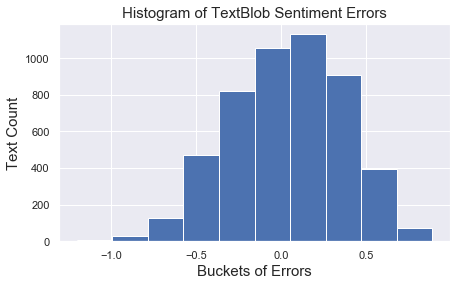

In [7]:
def get_histogram(data, title):
    plt.figure(figsize=(7, 4))
    plt.hist(data)
    plt.title(title, fontsize=15)
    plt.ylabel('Text Count', fontsize=15)
    plt.xlabel('Buckets of Errors', fontsize=15)
    plt.show()

get_histogram(df['vader_delta'], title='Histogram of VADER Sentiment Errors')
get_histogram(df['stanford_delta'], title='Histogram of Stanford NLP Sentiment Errors')
get_histogram(df['textblob_delta'], title='Histogram of TextBlob Sentiment Errors')

In [8]:
print(df['vader_delta'].mean())
print(df['stanford_delta'].mean())
print(df['textblob_delta'].mean())
print(df['vader_delta'].std())
print(df['stanford_delta'].std())
print(df['textblob_delta'].std())

-0.44015900199600805
0.2648157896541232
0.037828445929832026
0.6717925335021797
0.5079119308594398
0.33304666819455747


In [9]:
stats.shapiro(df['vader_delta'].to_numpy())

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/scipy/stats/morestats.py:1660: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


(0.9050846099853516, 0.0)

In [10]:
stats.shapiro(df['stanford_delta'].to_numpy())

(0.9965566396713257, 2.2496067231259076e-09)

In [11]:
stats.shapiro(df['textblob_delta'].to_numpy())

(0.9940632581710815, 1.503978013092308e-13)

In [12]:
stats.friedmanchisquare(df['textblob_delta'].to_numpy(), df['stanford_delta'].to_numpy(), df['vader_delta'].to_numpy())

FriedmanchisquareResult(statistic=3553.939866147236, pvalue=0.0)

In [13]:
stats.mannwhitneyu(df['textblob_delta'].to_numpy(), df['vader_delta'].to_numpy())

MannwhitneyuResult(statistic=5414306.5, pvalue=0.0)

In [14]:
stats.mannwhitneyu(df['textblob_delta'].to_numpy(), df['stanford_delta'].to_numpy())

MannwhitneyuResult(statistic=9007043.0, pvalue=1.4680120121954877e-132)

In [15]:
stats.mannwhitneyu(df['stanford_delta'].to_numpy(), df['vader_delta'].to_numpy())

MannwhitneyuResult(statistic=4681696.0, pvalue=0.0)

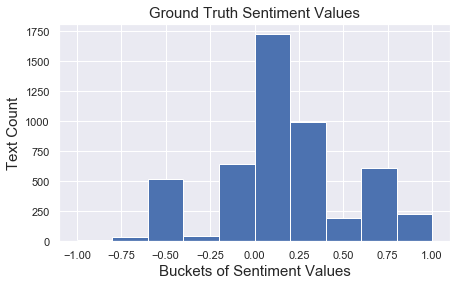

In [16]:
plt.figure(figsize=(7, 4))
plt.hist(df['rating'])
plt.title('Ground Truth Sentiment Values', fontsize=15)
plt.ylabel('Text Count', fontsize=15)
plt.xlabel('Buckets of Sentiment Values', fontsize=15)
plt.show()

## Time Testing

In [5]:
nta = NTA(nta='Upper West Side')
sentiment_df = nta.get_nta_sentiment_df()
sentiment_df = pd.DataFrame(np.repeat(sentiment_df.values,10,axis=0))

In [6]:
test_ranges = np.arange(50, 1050, 50)
vader_time, stanford_time, textblob_time = [], [], []
vader_analyzer = get_vader_analyzer()
stanford_nlp = get_stanford_nlp()
for test_range in test_ranges:
    print(f'Starting test for range {test_range}')
    start = time.time()
    _ = sentiment_df[:test_range][2].apply(lambda x: get_vader_sentiment(vader_analyzer, x))
    end = time.time()
    vader_time.append(end - start)
    start = time.time()
    _ = sentiment_df[:test_range][2].apply(lambda x: get_stanford_sentiment(stanford_nlp, x))
    end = time.time()
    stanford_time.append(end - start)
    start = time.time()
    _ = sentiment_df[:test_range][2].apply(lambda x: get_textblob_sentiment(x))
    end = time.time()
    textblob_time.append(end - start)

Starting test for range 50
Starting test for range 100
Starting test for range 150
Starting test for range 200
Starting test for range 250
Starting test for range 300
Starting test for range 350
Starting test for range 400
Starting test for range 450
Starting test for range 500
Starting test for range 550
Starting test for range 600
Starting test for range 650
Starting test for range 700
Starting test for range 750
Starting test for range 800
Starting test for range 850
Starting test for range 900
Starting test for range 950
Starting test for range 1000


0.07671136738614336


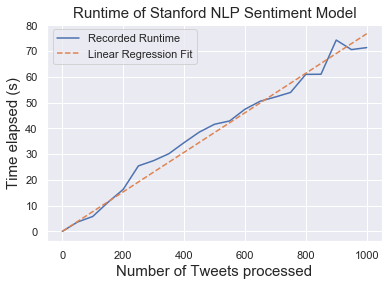

0.00029072310451015775


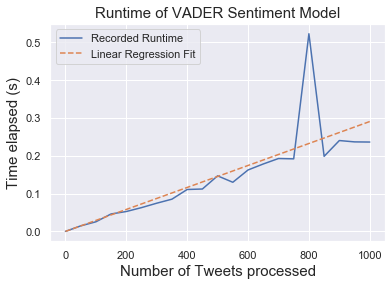

0.0003065490008231239


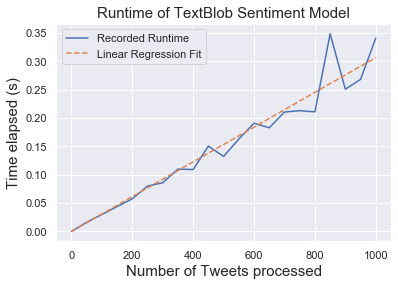

In [10]:
def plot_time_elapsed(times, model):
    x = np.array([0] + [50 * i for i in range(1, len(times) + 1)]).reshape(-1, 1)
    y = np.array([0] + times).reshape(-1, 1)
    reg = LinearRegression(fit_intercept=0).fit(x, y)
    fit = reg.coef_[0][0] * x
    print(reg.coef_[0][0])
    
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, label='Recorded Runtime')
    plt.plot(x, fit, linestyle='--', label='Linear Regression Fit')
    plt.title(f'Runtime of {model} Sentiment Model', fontsize=15)
    plt.xlabel('Number of Tweets processed', fontsize=15)
    plt.ylabel('Time elapsed (s)', fontsize=15)
    plt.legend()
    plt.show()
    
plot_time_elapsed(stanford_time, 'Stanford NLP')
plot_time_elapsed(vader_time, 'VADER')
plot_time_elapsed(textblob_time, 'TextBlob')

In [9]:
sample_tweets = sentiment_df[2].to_numpy()
vader_time, stanford_time, textblob_time = [], [], []
vader_analyzer = get_vader_analyzer()
stanford_nlp = get_stanford_nlp()
for i in range(len(sample_tweets)):
    if i % 100 == 0:
        print(f'{i}/{len(sample_tweets)} completed')
    tweet = sample_tweets[i]
    start = time.time()
    _ = get_vader_sentiment(vader_analyzer, tweet)
    end = time.time()
    vader_time.append(end - start)
    start = time.time()
    _ = get_stanford_sentiment(stanford_nlp, tweet)
    end = time.time()
    stanford_time.append(end - start)
    start = time.time()
    _ = get_textblob_sentiment(tweet)
    end = time.time()
    textblob_time.append(end - start)

0/1000 completed
100/1000 completed
200/1000 completed
300/1000 completed
400/1000 completed
500/1000 completed
600/1000 completed
700/1000 completed
800/1000 completed
900/1000 completed


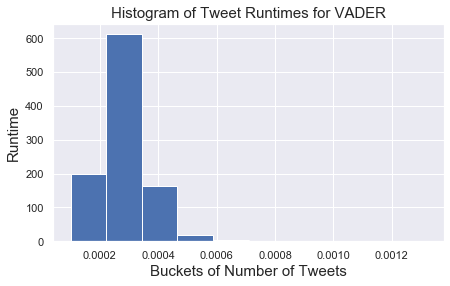

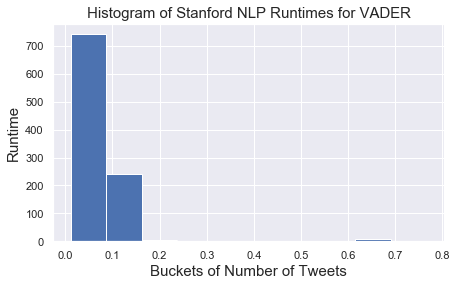

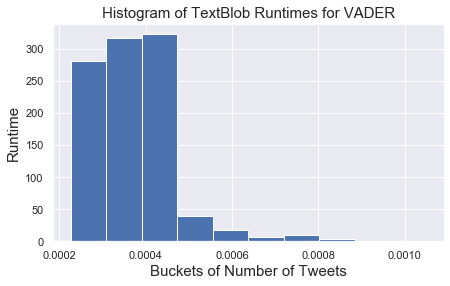

In [10]:
def get_histogram(data, title):
    plt.figure(figsize=(7, 4))
    plt.hist(data)
    plt.title(title, fontsize=15)
    plt.ylabel('Runtime', fontsize=15)
    plt.xlabel('Buckets of Number of Tweets', fontsize=15)
    plt.show()

get_histogram(vader_time, 'Histogram of Tweet Runtimes for VADER')
get_histogram(stanford_time, 'Histogram of Stanford NLP Runtimes for VADER')
get_histogram(textblob_time, 'Histogram of TextBlob Runtimes for VADER')

In [12]:
print(np.array(vader_time).mean())
print(np.array(stanford_time).mean())
print(np.array(textblob_time).mean())
print(np.array(vader_time).std())
print(np.array(stanford_time).std())
print(np.array(textblob_time).std())

0.00028823208808898926
0.06924257063865662
0.0003754289150238037
9.324788754971033e-05
0.07103707888614695
9.593353439040964e-05


In [13]:
stats.mannwhitneyu(vader_time, stanford_time)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)

In [15]:
stats.mannwhitneyu(vader_time, textblob_time)

MannwhitneyuResult(statistic=237643.5, pvalue=4.545178747871098e-92)

In [16]:
stats.mannwhitneyu(stanford_time, textblob_time)

MannwhitneyuResult(statistic=0.0, pvalue=0.0)